In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

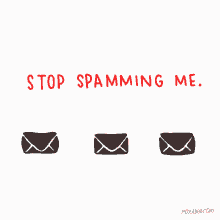

# **let’s get our environment ready with the libraries we’ll need and then import the data!**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-deep')
from sklearn.metrics import confusion_matrix
import nltk

**Check out the Data**

In [ ]:
df = pd.read_csv('/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv')
df.head()

In [ ]:
df.info()

# **Exploratory Data Analysis**

Let's use groupby to use describe by Category, this way we can begin to think about the features that separate ham and spam!

In [ ]:
df.groupby('Category').describe()

Let's make a new column to detect how long the text messages are

In [ ]:
df['Length'] = df['Message'].apply(len)
df.head()

Let's see the percentage of ham and spam in our dataset

In [ ]:
explode = (0.1,0)  
fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.pie(df['Category'].value_counts(), explode=explode,labels=['ham','spam'], autopct='%1.1f%%',
        shadow=True)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
df['Length'].plot.hist(bins = 150)

In [ ]:
df['Length'].describe()

One of the text has 910 characters, let's use masking to find this message:

In [ ]:
df[df['Length'] == 910]['Message'].iloc[0]

# **Text Cleaning**

Let’s clean the text for the messages in our dataset with NLP.

In [ ]:
import string
from nltk.corpus import stopwords

Let's create the function to remove all punctuation, remove all stopwords and returns a list of the cleaned text 

In [ ]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Check to make sure its working

In [ ]:
df['Message'].head(10).apply(text_process)

**Vectorization**

Now we have the messages as lists and we need to convert each of those messages into a vector that SciKit Learn's algorithm models can work with.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer 

In [ ]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['Message'])

Print total number of vocab words

In [ ]:
print(len(bow_transformer.vocabulary_))

Let's take one text message and get its bag-of-words counts as a vector, putting to use our new bow_transformer

In [ ]:
message4 = df['Message'][3]
print(message4)

Now let's see its vector representation

In [ ]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

Let's see which ones appear twice in our dataset

In [ ]:
print(bow_transformer.get_feature_names()[4066])
print(bow_transformer.get_feature_names()[9551])

Now let's transform the entire DataFrame of messages and create sparse matrix

In [ ]:
messages_bow = bow_transformer.transform(df['Message'])

In [ ]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

In [ ]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format((sparsity)))

# **TF-IDF**

Now let's compute term weighting and do normalisation with TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(messages_bow)
print(tfidf4)

# **Training a Random Forest model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=10, criterion='entropy',random_state=0)
classifier.fit(tfidf4, df['Category'])

Let's try classifying our single random message and checking how we do:

In [ ]:
print('predicted:', classifier.predict(tfidf4)[0])
print('expected:', df.Category[3])

**Model Evaluation**

Let's check out the accuracy of our model in entire dataset

In [ ]:
all_predictions = classifier.predict(messages_bow)
print(all_predictions)

Let's create classification report

In [ ]:
from sklearn.metrics import classification_report
print (classification_report(df['Category'], all_predictions))

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(df['Category'], all_predictions))

In the above evaluation, we evaluated accuracy on the same data we used for training. You should never actually evaluate on the same dataset you train on! the proper way is to split the data into a training set and test set,

**Train Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(df['Message'], df['Category'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

**Creating a Data Pipeline**

Let's run our model again and then predict the test set. We will create and use a pipeline for this purpose

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier()),  # train on TF-IDF vectors w/ SVM
])

In [ ]:
pipeline.fit(msg_train,label_train)

In [ ]:
predictions = pipeline.predict(msg_test)

# **Making Confusion Matrix**

Confusion Matrix is going to contain the correct predictions that our model made on the set as well as the incorrect predictions.

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(label_test,predictions)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Create classification report

In [ ]:
print(classification_report(predictions,label_test))

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(predictions,label_test))

# Please Upvote ! If you find this notebook is useful!
# Many Thanks

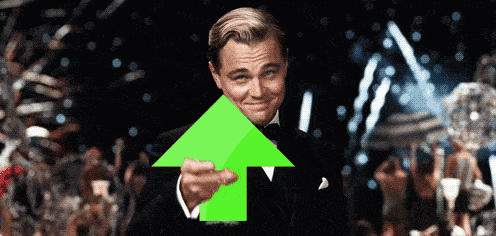